# GAN Getting Started

This notebook explores image generation for the Kaggle challenge
(I’m Something of a Painter Myself)[https://www.kaggle.com/competitions/gan-getting-started].

Through this notebook we will be using PyTorch to explore image generation
using VAEs. This is a slightly odd approach, but it does work as the latent
space used by VAEs can be tuned to represent images for different types of
decoders.

We will use a single universal encoding with two different style decoders.
We will then use our non-style images and feed them through the style
decoder to create branch new images in the desired style.

## EDA and Data Loading
We start off by writing our PyTorch `Dataset` here that we will use to load
both the style and non-style images. There is not much EDA to do here as the
data provided is just a set of images. 

We do not do any normalization in the dataset as we will be do the standard
normalization in the model itself.

In [ ]:
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import torch
import os
import os.path

base_path = "./gan-getting-started/"

class ImageDataset(Dataset):
  imsize = 256

  alter_tranforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
  ])

  base_transform = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor(),
  ])

  def norm(x):
    return x

  def unnorm(x):
    return x

  def __init__(self, folder, alter=False):
    super().__init__()

    folder = os.path.expanduser(folder)
    paths = []
    for root, _, fnames in os.walk(folder, followlinks=True):
      for fname in sorted(fnames):
        if fname.endswith("jpg"):
          path = os.path.join(root, fname)
          paths.append(path)

    self.paths = paths
    self.alter = alter

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    img = Image.open(self.paths[idx])
    if self.alter:
      img = ImageDataset.alter_tranforms(img)
    img = ImageDataset.base_transform(img)
    img = ImageDataset.norm(img)
    return img

  def get_image(self, idx):
    img = self[idx]
    img = ImageDataset.unnorm(img)
    img = transforms.functional.to_pil_image(img)
    return img

style_ds = ImageDataset(base_path + 'monet_jpg', alter=True)
content_ds = ImageDataset(base_path + 'photo_jpg')

print("style len:", len(style_ds))
print("content len:", len(content_ds))

style len: 300
content len: 7038


We go on to print a sample of the image data now that it's loaded, and we can see that 
the pixel data has been converted to a 0-1 range, as is the normal style done
by the Viztorch transformer functions.

We then print one of the sample style images.

tensor([[[0.7059, 0.7569, 0.7922,  ..., 0.8431, 0.8039, 0.7569],
         [0.7294, 0.7451, 0.7686,  ..., 0.8549, 0.8157, 0.7686],
         [0.7294, 0.7255, 0.7333,  ..., 0.8784, 0.8431, 0.8000],
         ...,
         [0.6118, 0.7490, 0.7686,  ..., 0.6078, 0.5608, 0.5373],
         [0.6039, 0.7686, 0.7804,  ..., 0.5412, 0.5529, 0.5137],
         [0.5725, 0.7216, 0.7843,  ..., 0.4510, 0.4902, 0.4627]],

        [[0.6980, 0.7490, 0.7922,  ..., 0.8039, 0.7490, 0.7020],
         [0.7176, 0.7451, 0.7647,  ..., 0.8078, 0.7608, 0.7137],
         [0.7216, 0.7255, 0.7294,  ..., 0.8314, 0.7882, 0.7451],
         ...,
         [0.5490, 0.6941, 0.7216,  ..., 0.3490, 0.2824, 0.2510],
         [0.5373, 0.7059, 0.7294,  ..., 0.3725, 0.3765, 0.3255],
         [0.5020, 0.6588, 0.7216,  ..., 0.3373, 0.3569, 0.3294]],

        [[0.5490, 0.6000, 0.6588,  ..., 0.7059, 0.6471, 0.5961],
         [0.5882, 0.6118, 0.6471,  ..., 0.7137, 0.6588, 0.6078],
         [0.6235, 0.6235, 0.6471,  ..., 0.7373, 0.6863, 0.

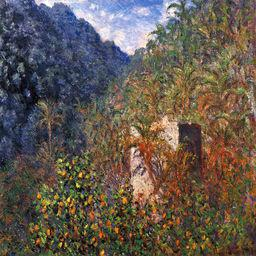

In [2]:
display(style_ds[0])
display(style_ds.get_image(22))

We also print one the non-style images here.

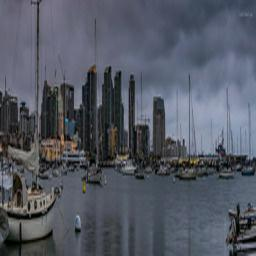

In [3]:
display(content_ds.get_image(123))

## Model

We define the model below. The structure is a standard VAE structure
where we use a stack of convolutions in the encoder that reduce down
to a flat latent space. We then define a decoder that uses the same sizing
as the encoder, but uses a stack of transposed CNNs to upsample the image data.
The decoder is then followed by a single convolutional layer.

We have opted not to use batch normalization here to reduce bluryness,
and instead we use a single Layer Norm in the latent space encoder. This still
serves to stabalize the gradient without producing as much random variation
between the convolution layers.

In [ ]:
import torch
from torch import nn

class Model(nn.Module):
  mean = torch.tensor([0.485, 0.456, 0.406])
  std = torch.tensor([0.229, 0.224, 0.225])

  #def __init__(self, ae_arch=[32, 32, 64, 64, 128, 256, 512], latent_dim=256, stride=2):
  def __init__(self, ae_arch=[128, 196, 256, 512], latent_dim=512, strides=[4, 4, 4, 2]):
    super().__init__()

    act = nn.LeakyReLU # nn.GELU
    self.latent_dim = latent_dim

    self.encoder = nn.Sequential()
    for idx, x in enumerate(ae_arch):
      s = strides[idx]
      self.encoder.extend([
        nn.LazyConv2d(x, s+1, stride=s, padding=1, bias=True),
        act(),
      ])
    self.encoder.extend([
      nn.Flatten(),
      nn.LazyLinear(latent_dim*2, bias=False),
      nn.LayerNorm(latent_dim*2),
      act(),
      nn.LazyLinear(latent_dim*2),
    ])

    def decoder():
      net = nn.Sequential(
        nn.LazyLinear(ae_arch[-1]*4),
        nn.Unflatten(1, (ae_arch[-1], 2, 2)),
      )
      rstrides = list(reversed(strides))
      for idx, x in enumerate(reversed(ae_arch)):
        s = rstrides[idx]
        net.extend([
          nn.LazyConvTranspose2d(x, s+1, stride=s, padding=1,
                                 output_padding=1, bias=True),
          act(),
        ])
      net.extend([
        nn.LazyConv2d(3, rstrides[-1]+1, padding='same'),
        nn.Sigmoid(),
      ])
      return net

    self.style_decoder = decoder()
    self.content_decoder = decoder()

  def forward(self, x):
    pass

  def encode(self, x):
    if len(x.shape) == 3:
      x = x.unsqueeze(0)

    m = Model.mean.view(-1, 1, 1).to(x.device)
    s = Model.std.view(-1, 1, 1).to(x.device)
    x = (x - m) / s

    x = self.encoder(x)
    mu = x[:, :self.latent_dim]
    logvar = x[:, self.latent_dim:]
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    x = eps * std + mu
    return x, mu, logvar

  def both(self, x):
    x, mu, logvar = self.encode(x)
    xs = self.style_decoder(x)
    xc = self.content_decoder(x)
    return xs, xc, mu, logvar

  def style(self, x):
    x, mu, logvar = self.encode(x)
    x = self.style_decoder(x)
    return x, mu, logvar

  def content(self, x):
    x, mu, logvar = self.encode(x)
    x = self.content_decoder(x)
    return x, mu, logvar

  def loss(self, a, b, mu, logvar):
    recon_loss = nn.functional.mse_loss(a, b)
    kld_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp(), dim=1), dim=0)
    return recon_loss, kld_loss

model = Model()
img = style_ds[0].unsqueeze(0)
encoded = model.encode(img)[0]
print(encoded.shape)
print(model.style_decoder(encoded).shape)

torch.Size([1, 512])
torch.Size([1, 3, 256, 256])


## Training

We define our training loop below. We used a plateau LR reducer to step
down the LR based on our style decoder loss. We also offer several training
HPs that influence loss contribution. The `pretrain` argument here is used
to switch between two different loss goals. When pretrain is true, we only
train the style decoder. When it is false, we train the style and content
decoder, as well as a special kind of cross loss where we use one decoder
to decoder the other type of image, which helps encourage alignment on
which latent features are used to describe the image.

We proceed to train the model in 3 phases:
* Pretraining with just the style images
* Cross training with style and content images
* Another small pretraining step with just the style images again.

Our loss gets down to 0.006 for pretraining, 0.03 for cross training,
then back to 0.007 for the final pretraining step.

In [5]:
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# enable tensorfloat32
# torch.set_float32_matmul_precision('high')

def train(model: Model, epochs, minibatch_size=64, initial_lr=1e-3, 
          cross_loss=1e-2, min_lr=1e-8, closs_weight=1e-1, pretrain=True):
  optimizer = torch.optim.Adam(model.parameters(), initial_lr)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=30, min_lr=min_lr)

  style_dl = DataLoader(style_ds, minibatch_size, shuffle=True,
                num_workers=5,
                prefetch_factor=1,
                pin_memory=torch.cuda.is_available())

  content_dl = DataLoader(content_ds, minibatch_size, shuffle=True,
                num_workers=5,
                prefetch_factor=1,
                pin_memory=torch.cuda.is_available())
  
  # kld_weight = minibatch_size / min(len(style_ds), len(content_ds))

  for epoch in range(epochs):
    anneal_frac = epoch / epochs
    kld_weight = 1e-5 * anneal_frac

    model.train()

    minibatches = 0
    total_closs = 0
    total_sloss = 0

    if pretrain:
      for xs in style_dl:
        optimizer.zero_grad()

        xs = xs.to(device)
        os, mu, logvar = model.style(xs)
        sloss_r, sloss_k = model.loss(os, xs, mu, logvar)
        sloss = sloss_r + sloss_k * kld_weight
        sloss.backward()
        sloss = sloss.item()
        closs = 0
        sloss_k = sloss_k.item()
        sloss_r = sloss_r.item()

        optimizer.step()
        optimizer.zero_grad()
        model.eval()

        total_closs += closs
        total_sloss += sloss_r
        minibatches += 1
    else:
      for xs, xc in zip(style_dl, content_dl):
        optimizer.zero_grad()

        # TODO: b/w version of loss for content?
        xs = xs.to(device)
        os, oc, mu, logvar = model.both(xs)
        sloss_r, sloss_k = model.loss(os, xs, mu, logvar)
        sloss = sloss_r + sloss_k * kld_weight
        sloss += nn.functional.mse_loss(oc, xs) * cross_loss
        sloss.backward()
        sloss = sloss.item()
        sloss_k = sloss_k.item()
        sloss_r = sloss_r.item()

        xc = xc.to(device)
        os, oc, mu, logvar = model.both(xc)
        closs_r, closs_k = model.loss(oc, xc, mu, logvar)
        closs = closs_r + closs_k * kld_weight
        closs += nn.functional.mse_loss(os, xc) * cross_loss
        (closs * closs_weight).backward()
        closs = closs.item()
        closs_k = None
        closs_r = None

        optimizer.step()
        optimizer.zero_grad()
        model.eval()

        total_closs += closs
        total_sloss += sloss_r
        minibatches += 1

    epoch_closs = total_closs / minibatches
    epoch_sloss = total_sloss / minibatches
    scheduler.step(sloss_r)
    lr = scheduler.get_last_lr()[0]
    print("epoch:", epoch+1, "closs:", epoch_closs, "sloss:", epoch_sloss, "lr:", lr, "sloss_k:", sloss_k)
    if lr <= (min_lr + 1e-10):
      print("stopping early")
      break

model = model.to(device)

train(torch.compile(model), 1000)
train(torch.compile(model), 1000, pretrain=False, initial_lr=1e-4)
train(torch.compile(model), 50)

epoch: 1 closs: 0.0 sloss: 0.05372366607189179 lr: 0.001 sloss_k: 65.60372924804688
epoch: 2 closs: 0.0 sloss: 0.05413063243031502 lr: 0.001 sloss_k: 148.30442810058594
epoch: 3 closs: 0.0 sloss: 0.05397358313202858 lr: 0.001 sloss_k: 250.06179809570312
epoch: 4 closs: 0.0 sloss: 0.053697866201400754 lr: 0.001 sloss_k: 388.58258056640625
epoch: 5 closs: 0.0 sloss: 0.04897267296910286 lr: 0.001 sloss_k: 320.3250732421875
epoch: 6 closs: 0.0 sloss: 0.04918609783053398 lr: 0.001 sloss_k: 549.52099609375
epoch: 7 closs: 0.0 sloss: 0.04522651135921478 lr: 0.001 sloss_k: 756.1917114257812
epoch: 8 closs: 0.0 sloss: 0.04107459485530853 lr: 0.001 sloss_k: 890.905029296875
epoch: 9 closs: 0.0 sloss: 0.03764746934175491 lr: 0.001 sloss_k: 1252.3604736328125
epoch: 10 closs: 0.0 sloss: 0.03631804883480072 lr: 0.001 sloss_k: 1424.9510498046875
epoch: 11 closs: 0.0 sloss: 0.03512386828660965 lr: 0.001 sloss_k: 1252.5260009765625
epoch: 12 closs: 0.0 sloss: 0.03430470451712608 lr: 0.001 sloss_k: 116

### HP Tuning

We opted to do manual HP tuning and we record the results in the table below.

We use two different convolutional architectures that will be referenced in the table:
* Large: `32, 32, 64, 64, 128, 256, 512` (stride of 2)
* Medium: `128, 196, 256, 512` (stride of [4, 4, 2, 2])

Loss | Params  | Description |
-----|---------|-------------|
0.008 | 1024 latent, medium | Large latent space with the medium CNN |
0.008 | 512 latent, medium | Medium latent space with the medium CNN |
0.009 | 256 latent, medium | Smaller latent space with the medium CNN |
0.012 | 128 latent, medium | Smal latent space with the medium CNN |
0.009 | 512 latent, large | Medium latent space with the large CNN |

We can see that the ideal latent space is 512, and that we don't really
benefit from the deeper and larger CNN. So we decide to do our training
with a latent space of 512 and the medium CNN.

### Results

We print a few results below using both our style and content images.
We can see that the representation of the style images is pretty good,
and that when we use the content images we get a brand new image
that has a similar shape and layout to the content images!

tensor([[[[0.7603, 0.8337, 0.8762,  ..., 0.3955, 0.4301, 0.4488],
          [0.8087, 0.8833, 0.9126,  ..., 0.3585, 0.3819, 0.4070],
          [0.8433, 0.9112, 0.9370,  ..., 0.3443, 0.3664, 0.3960],
          ...,
          [0.4799, 0.4631, 0.4385,  ..., 0.4220, 0.4197, 0.4501],
          [0.5047, 0.4979, 0.4928,  ..., 0.4359, 0.4376, 0.4627],
          [0.5180, 0.5149, 0.5215,  ..., 0.4669, 0.4693, 0.4834]],

         [[0.7472, 0.8078, 0.8396,  ..., 0.4058, 0.4308, 0.4503],
          [0.7895, 0.8491, 0.8712,  ..., 0.3760, 0.3974, 0.4112],
          [0.8156, 0.8615, 0.8880,  ..., 0.3483, 0.3659, 0.3886],
          ...,
          [0.5048, 0.4838, 0.4656,  ..., 0.2939, 0.3124, 0.3535],
          [0.5244, 0.5102, 0.5048,  ..., 0.3267, 0.3567, 0.3839],
          [0.5349, 0.5323, 0.5359,  ..., 0.3687, 0.3956, 0.4150]],

         [[0.6710, 0.7120, 0.7254,  ..., 0.2939, 0.3333, 0.3547],
          [0.7148, 0.7241, 0.7276,  ..., 0.2551, 0.2823, 0.3100],
          [0.7278, 0.7240, 0.7110,  ..., 0

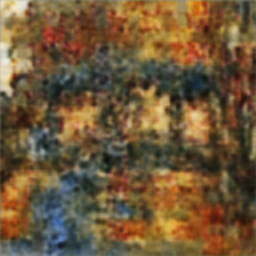

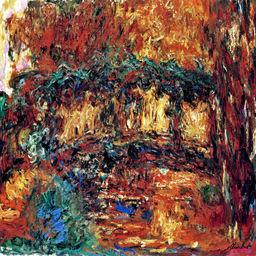

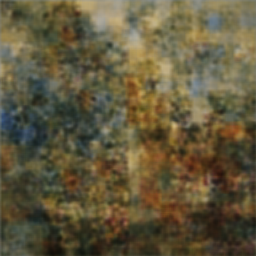

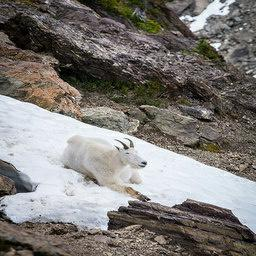

In [14]:
import random

style_idx = int(random.random() * len(style_ds))
style_img = style_ds[style_idx]
content_idx = int(random.random() * len(content_ds))
content_img = content_ds[content_idx]

def show_output(x: torch.Tensor):
  x = x.cpu().squeeze(0)
  x = ImageDataset.unnorm(x)
  x = x.clamp(0, 1)
  x = transforms.functional.to_pil_image(x)
  display(x)

model.eval()

out = model.style(style_img.to(device).unsqueeze(0))[0]
print(out)
show_output(out)
display(style_ds.get_image(style_idx))

out = model.style(content_img.to(device).unsqueeze(0))[0]
show_output(out)
display(content_ds.get_image(style_idx))

# New Images

Below we print some of our newly generated images using our content
images as inputs!

There is not a ton of definition to the images, but they are all
unique and the do look like our painting style!

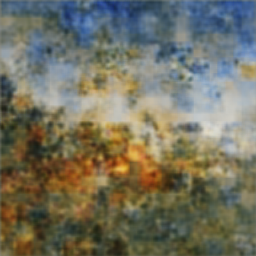

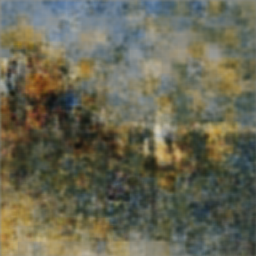

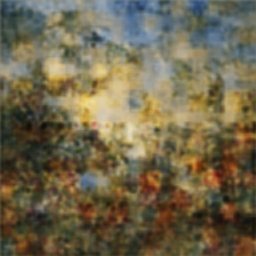

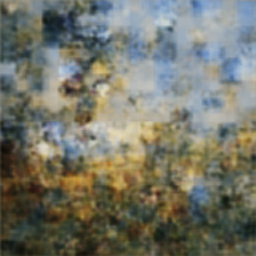

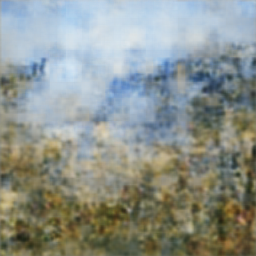

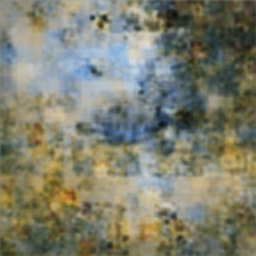

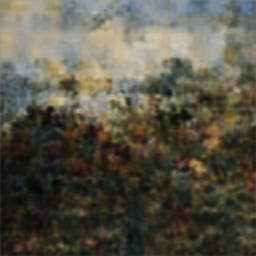

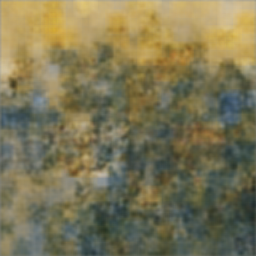

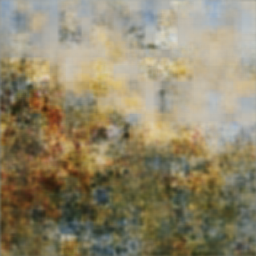

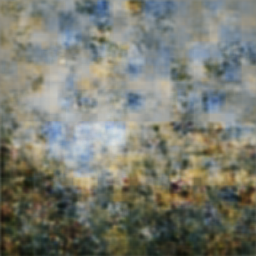

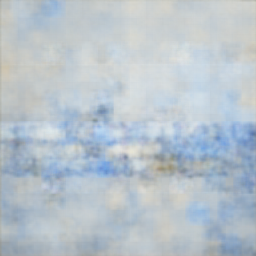

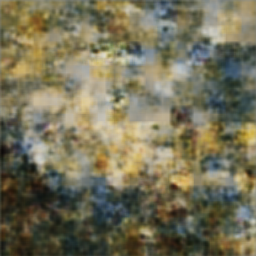

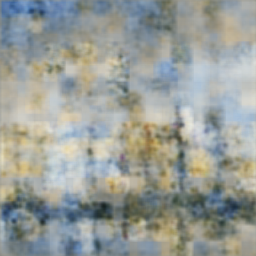

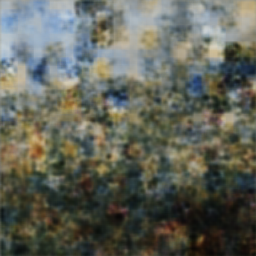

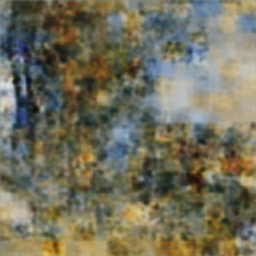

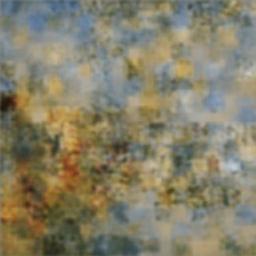

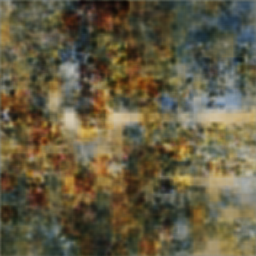

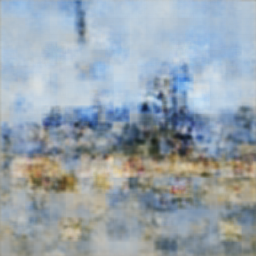

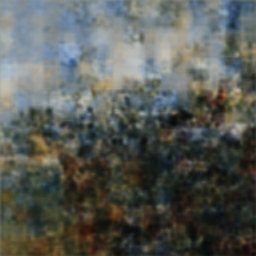

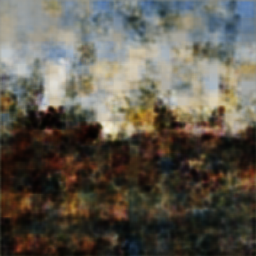

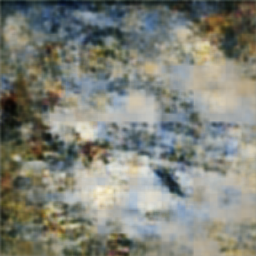

In [18]:
created = 0
for x in content_ds:
  out = model.style(x.to(device).unsqueeze(0))[0]
  show_output(out)
  created += 1
  if created > 20: break

# Conclusion

We have succesfully trained a VAE model to perform style transfer! This is not 
the general use-case for VAEs, but we've show there is some success in being able
to use a common encoder and different decoders to represent a "common ground"
latent space encoding that is capable of performing style transfer.

Now, this method would have had better results if we used a different method. VAEs
are not normally known for style transfer, and there are better architectures for
this case, but this toy model does go to show that latent representations of image
can be used to transform the image style roughly, or at least be used as an 
interesting seed to generate brand new images!